In [4]:
from src.BOVW import BOVW
from src.ColorHistogram import ColorHistogram
from src.DeepModel import DeepModel
from src.CombinedModel import CombinedModel
from src.CNN import CNN
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import dill
from tqdm import tqdm
from time import perf_counter
import os
from src.Preprocess import find_face_and_preprocess
from mtcnn import MTCNN

## Split new features (only if needed)

In [2]:
#feature_path = "./src/CNN_transfer/cnn_withus_maxpool/cnn_train_features.pkl"
#labels_path = "./src/CNN_transfer/cnn_withus_maxpool/cnn_train_labels.pkl"
#
#with open(feature_path, 'rb') as f: feature = dill.load(f)
#with open(labels_path, 'rb') as f: labels = dill.load(f)
#
#feature_savory = [feature[i] for i in np.where(np.asarray(labels)=='savory')[0]]
#feature_unsavory = [feature[i] for i in np.where(np.asarray(labels)=='unsavory')[0]]
#
#with open("./src/CNN_transfer/cnn_withus_maxpool/feature_savory.pkl", 'wb') as f: feature = dill.dump(feature_savory, f)
#with open("./src/CNN_transfer/cnn_withus_maxpool/feature_unsavory.pkl", 'wb') as f: feature = dill.dump(feature_unsavory, f)

## Loading models

In [18]:
# BOVW paths
new_bovw_path = './src/BOVW/bovw_withus/bovw.pkl'
new_bovw_savory = './src/BOVW/bovw_withus/feature_savory.pkl'
new_bovw_unsavory = './src/BOVW/bovw_withus/feature_unsavory.pkl'
new_train_image_path_bovw = './src/BOVW/bovw_withus/train_paths.pkl'
# Color paths
new_color_path = "./src/Color/color_withus/histogram_model.pkl"
new_color_savory = "./src/Color/color_withus/feature_savory.pkl"
new_color_unsavory = "./src/Color/color_withus/feature_unsavory.pkl"
new_train_image_path_color = './src/Color/color_withus/train_paths.pkl'
# Combined paths
new_combined_path = "./src/Combined_descriptors/combined_withus/combined_model.pkl"
# Siamese model paths
classifier_path = "./src/CNN_training/Classifier/svm_final_nu03.sav"
siamese_embeddings = "./src/CNN_training/final_siamese_embedding_model"
siamese_savory = "./src/CNN_training/Features/feature_savory.pkl"
siamese_unsavory = "./src/CNN_training/Features/feature_unsavory.pkl"
image_train_paths = "./src/CNN_training/Features/path_final.pkl"
# CNN
cnn_path = './src/CNN/trained_cnn/'
cnn_savory = './src/CNN/cnn_withus/feature_savory.pkl'
cnn_unsavory = './src/CNN/cnn_withus/feature_unsavory.pkl'
cnn_image_train_paths = "./src/CNN/cnn_withus/cnn_train_paths.pkl"

In [5]:
detector = MTCNN()

In [17]:
#model = DeepModel(
#        classifier_path, 
#        siamese_embeddings, 
#        image_train_paths, 
#        siamese_savory,
#        siamese_unsavory, 
#        (200, 200)
#        )
color_model = ColorHistogram.load_model(new_color_path)
bovw_model = BOVW.load_model(new_bovw_path)
combined_model = CombinedModel.load_model(new_combined_path)
cnn_model = CNN(cnn_path)

## Evaluate CBIR performances on new image of ourselves (live version)

In [7]:
import cv2
from cv2 import VideoCapture
from PIL import Image
import tempfile

In [8]:
def imageSubplot(similar_s, similar_u, dist_s, dist_u):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))
    fig.suptitle('** I row: Savory - II row Unsavory **', fontsize=15)
    idx = np.argsort(np.argsort(np.concatenate((dist_s[0], dist_u[0]))))
    for i, path in enumerate(similar_s):
        plt.subplot(2, 5, i+1)
        plt.title(f"/{i+1} - Rank: {idx[i]+1} - dist: {np.round(dist_s[0][i], decimals=3)}")
        plt.axis('off')
        plt.imshow(plt.imread(path))
    for i, path in enumerate(similar_u):
        plt.subplot(2, 5, i+6)
        plt.title(f"/{i+6} - Rank: {idx[i+5]+1}- dist: {np.round(dist_u[0][i], decimals=3)}")
        plt.axis('off')
        plt.imshow(plt.imread(path))
    #plt.savefig("./cbir.jpg", bbox_inches='tight')
    plt.show()

In [19]:
def start_demo():  
    try:
        cam = VideoCapture(0)
        print("recording...")
        while True and cam.isOpened():
            s, frame = cam.read()   # frame is a numpy.ndarray
            cv2.imshow('frame', frame)
            if not s:
                break
            if cv2.waitKey(20) & 0xFF == ord('q'):
                img = Image.fromarray(frame).convert('RGB')
                r, g, b = img.split()
                result = Image.merge('RGB', (b, g, r))  # To resolve blueish image
                result.save("./temp.jpg")
                faces = find_face_and_preprocess("./temp.jpg", detector)
                if len(faces) >= 1:
                    for i, f in enumerate(faces):
                        f = (f*255).astype('uint8')
                        image = Image.fromarray(f)
                        image.save("./temp_crop.jpg")
                        result, most_similar_s, most_similar_u, feature, dist_s, dist_u = BOVW.cbir(new_bovw_path, "./temp_crop.jpg", new_bovw_savory, new_bovw_unsavory, new_train_image_path_bovw)
                        print(result[0])
                        # CBIR
                        imageSubplot(most_similar_s, most_similar_u, dist_s, dist_u)
                else: print("faccia non trovata...")
                break
        cam.release()
        cv2.destroyAllWindows()
    except Exception as e:
        print("error...", e)
        cam.release()
        cv2.destroyAllWindows()

recording...
1/1 [==============================] - 0s 11ms/step
BOVW computed in: 0.001349799999957213
KDTree computed in: 0.14326249999999163


c:\Users\Alessandro\AppData\Local\Programs\Python\Python38\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


5 most similar found in: 0.002832699999999022
savory


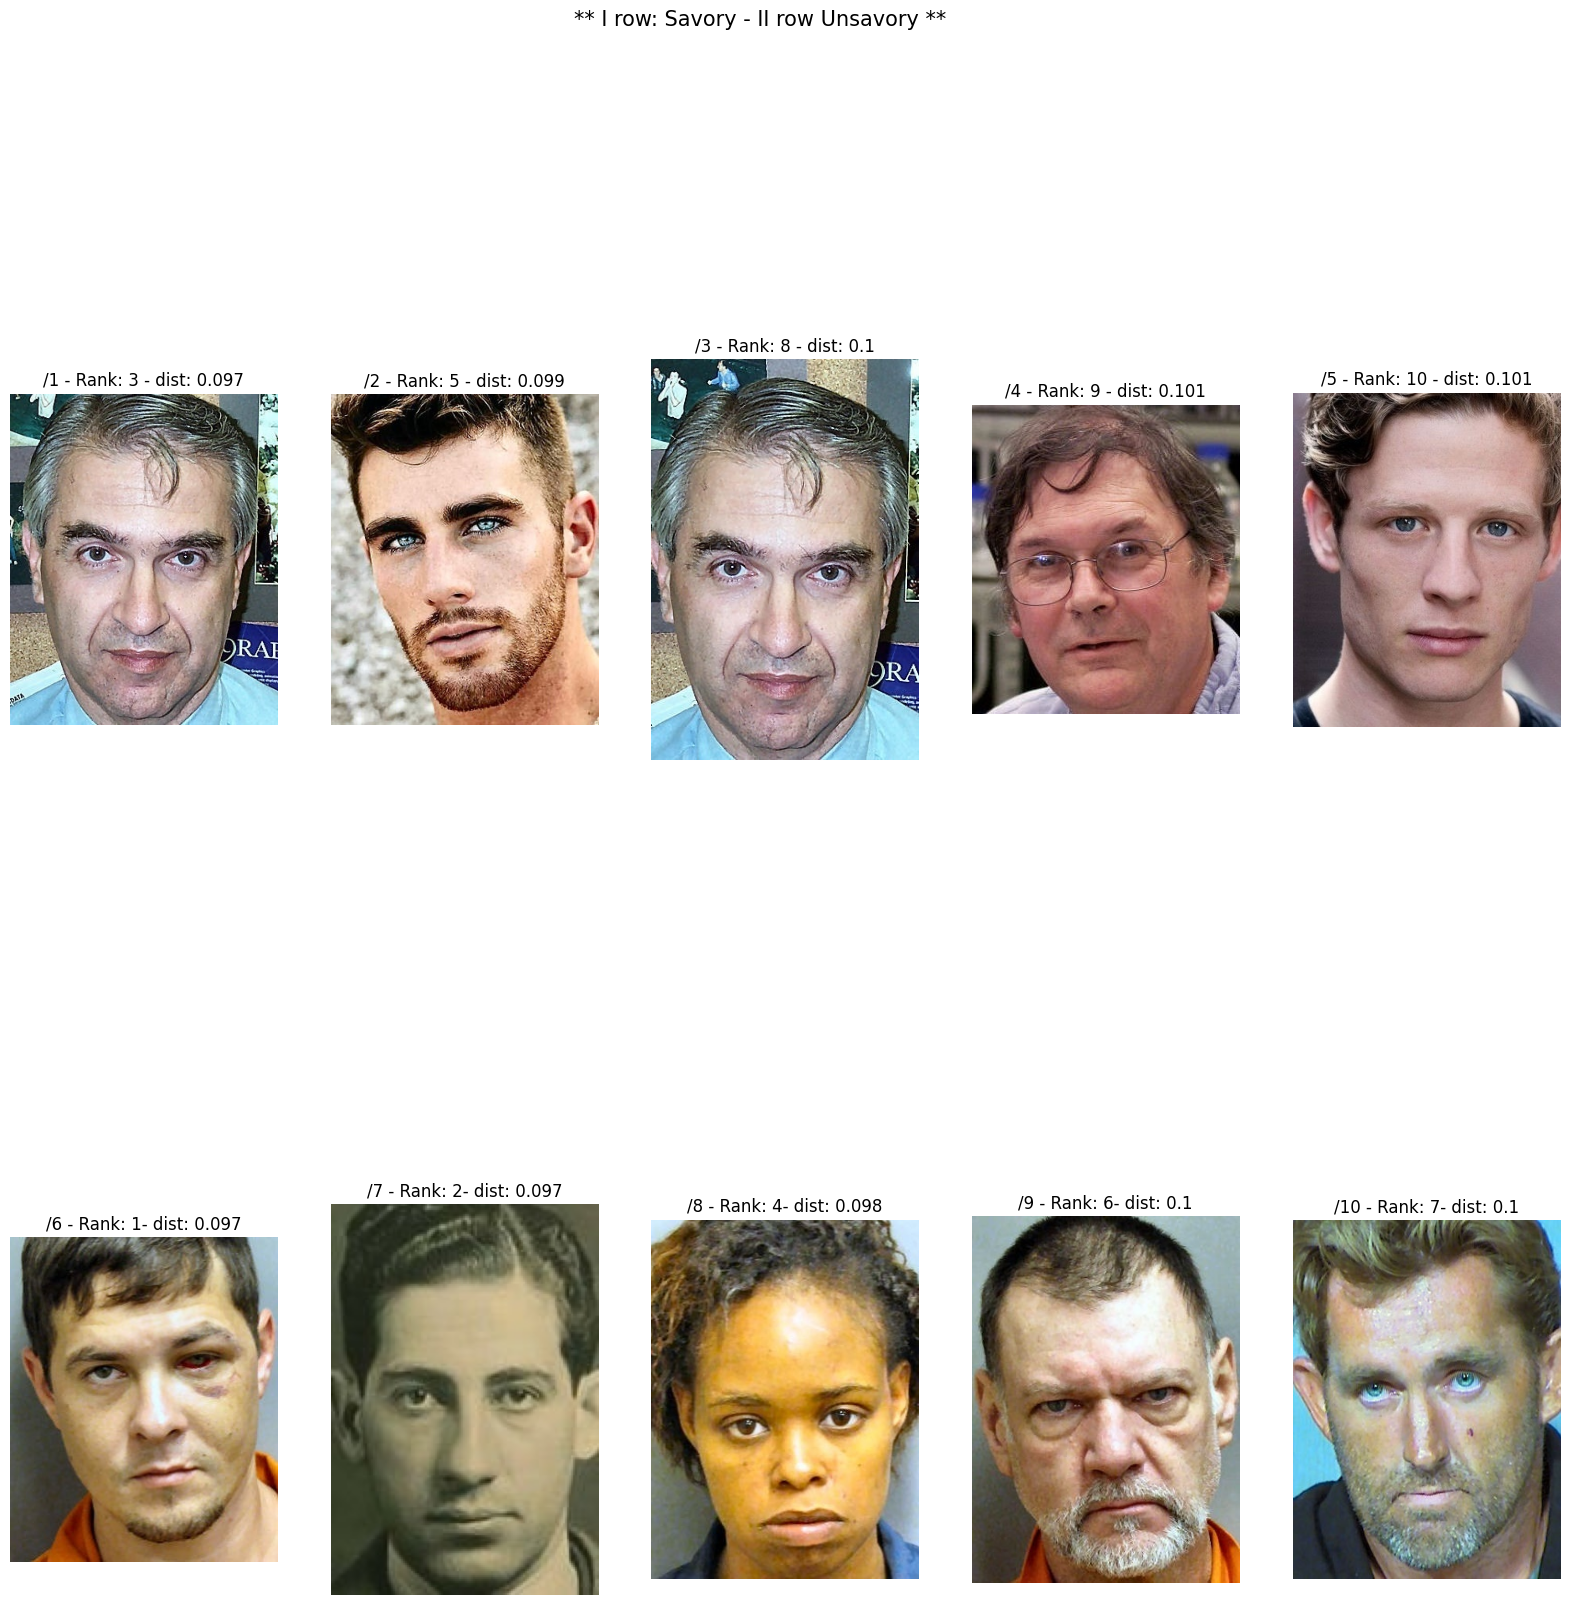

In [21]:
# Press q to get image from recorder
start_demo()

### Offline version

C:\Users\Jarvis\AppData\Local\Temp\tmpmdxcde9i
1/1 [==============================] - 0s 146ms/step
BOVW computed in: 0.00244640000001084
KDTree computed in: 1.0496248999999978
5 most similar found in: 0.019409099999990076
savory


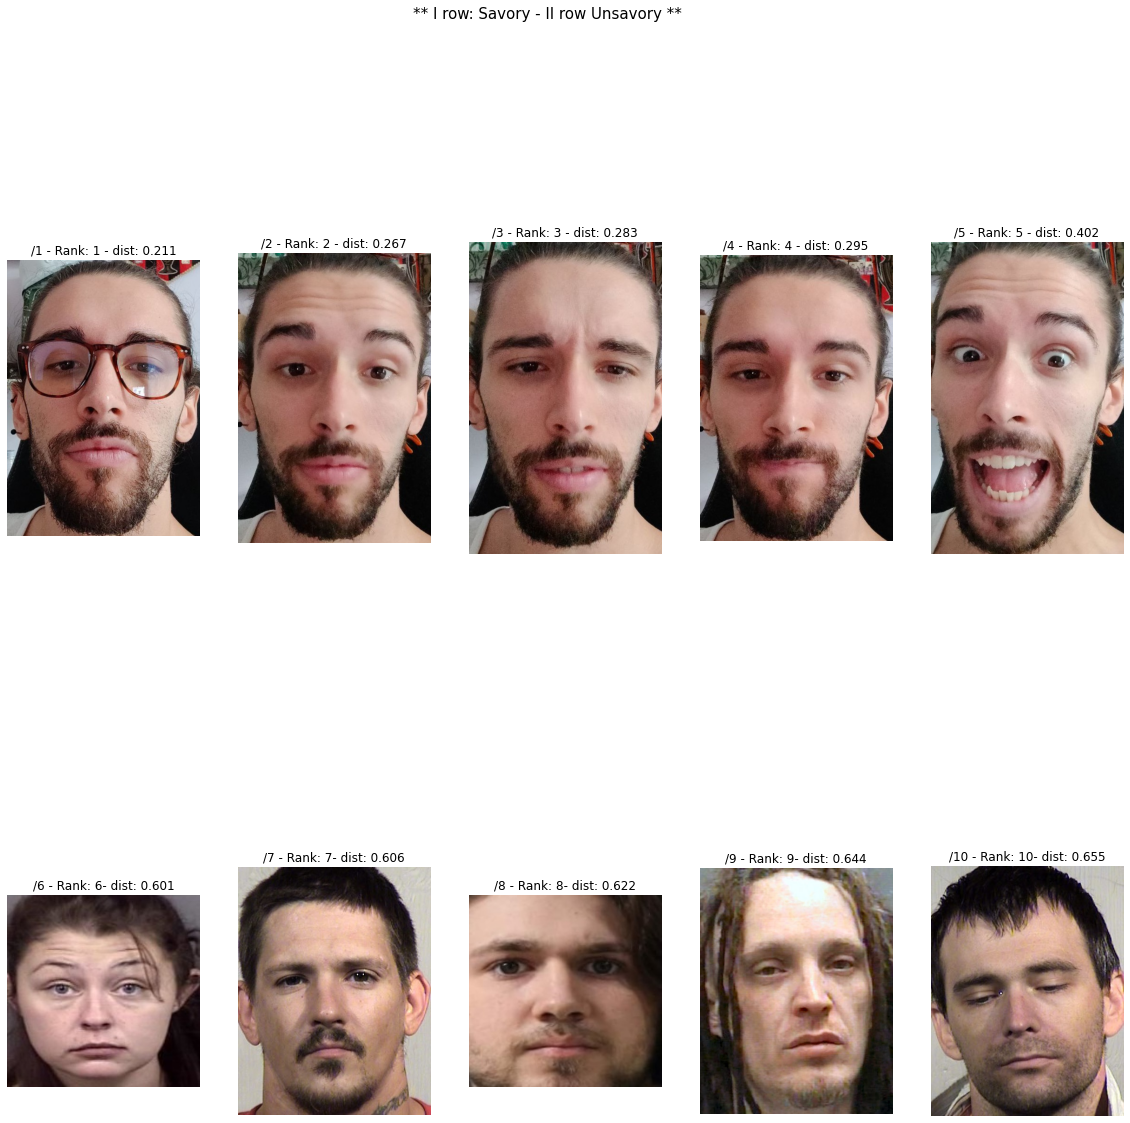

In [9]:
img_path = "C:/Users/Jarvis/Desktop/io3.jpg"

temp_dir = tempfile.TemporaryDirectory()
print(temp_dir.name)

faces = find_face_and_preprocess(img_path, detector)
if len(faces) >= 1:
    for i, f in enumerate(faces):
        image = Image.fromarray(f)
        image.save(temp_dir.name+"./temp_crop.jpg")
        #result, most_similar_s, most_similar_u, feature, dist_s, dist_u = ColorHistogram.cbir(new_color_path, temp_dir.name+"./temp_crop.jpg", new_color_savory, new_color_unsavory, new_train_image_path_color)                        
        #result, most_similar_s, most_similar_u, feature, dist_s, dist_u = cnn_model.cbir(temp_dir.name+"./temp_crop.jpg", cnn_savory, cnn_unsavory, cnn_image_train_paths)                        
        result, most_similar_s, most_similar_u, feature, dist_s, dist_u = CombinedModel.cbir(new_combined_path, temp_dir.name+"./temp_crop.jpg", None, new_train_image_path_color)                        
        print(result[0])
        # CBIR
        imageSubplot(most_similar_s, most_similar_u, dist_s, dist_u)
else: print("faccia non trovata...")
